##Modelo Predictivo de Prepagos Hipotecarios
# Modelos Alternativos

El objetivo de esta sección es explorar diversas técnicas para identificar el de mejor desempeño en el objetivo de predicción.

##Carga de información

Se cargan las librerías necesarias y el archivo con los datos ya preprocesados.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, learning_curve
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, precision_recall_curve, average_precision_score,
    classification_report, confusion_matrix
)
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, mutual_info_classif, RFECV
from sklearn.decomposition import PCA
from functools import partial

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
import itertools
import shap

plt.style.use("seaborn-v0_8")
sns.set_palette("viridis")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Cargar archivo Excel
file_path = "/content/drive/MyDrive/MNA/Proyecto Integrador/Modelos Alternativos/datos_preprocesados2.xlsx"
df = pd.read_excel(file_path, sheet_name = "Datos")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7381 entries, 0 to 7380
Data columns (total 36 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   pla_credit                             7381 non-null   int64  
 1   edad_cliente                           7381 non-null   float64
 2   score                                  7381 non-null   float64
 3   tasa                                   7381 non-null   float64
 4   plazo_original_meses                   7381 non-null   float64
 5   edad_credito                           7381 non-null   float64
 6   cantidad_prepago_ratio                 7381 non-null   float64
 7   prepago_total_ratio                    7381 non-null   float64
 8   enganche_ratio                         7381 non-null   float64
 9   cantidad_prepago_1                     7381 non-null   float64
 10  cantidad_prepago_2                     7381 non-null   float64
 11  cant

A continuación filtraremos los créditos con los que no se cuenta información antes de septiembre 2025. Al ajustar distintos modelos, se identificó que los modelos se equivocaban principalmente en los créditos sin suficiente información, por lo que se aplicará este filtro y se incorporará en los supuestos del modelo, para precisar que únicamente se enfoca en los créditos que cuenten con historia desde, al menos, 3 meses antes del mes de predicción.

In [ ]:
df = df[df['filtro oct'].isnull()]
df = df[df['filtro sep'].isnull()]
df = df.drop(columns=['filtro oct', 'filtro sep', 'filtro ago'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6303 entries, 0 to 7380
Data columns (total 33 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   pla_credit                             6303 non-null   int64  
 1   edad_cliente                           6303 non-null   float64
 2   score                                  6303 non-null   float64
 3   tasa                                   6303 non-null   float64
 4   plazo_original_meses                   6303 non-null   float64
 5   edad_credito                           6303 non-null   float64
 6   cantidad_prepago_ratio                 6303 non-null   float64
 7   prepago_total_ratio                    6303 non-null   float64
 8   enganche_ratio                         6303 non-null   float64
 9   cantidad_prepago_1                     6303 non-null   float64
 10  cantidad_prepago_2                     6303 non-null   float64
 11  cantidad_

# Parte 1: Modelo de Clasificación

**- Variable objetivo:** 'prepago_dic' (1 = el cliente prepaga en diciembre 2024; 0 = no prepaga).

**- Tipo de modelo:** Clasificación supervisada.

**Tratamiento de datos y balance de clases**

Los datos fueron previamente estructurados, transformados y escalados. Sin embargo, se identificó un desequilibrio en las clases (mayor proporción de clientes sin prepago). Para mitigar este sesgo y evitar un modelo sobreajustado, se aplicó una submuestra aleatoria (undersampling) de la clase mayoritaria, igualando el número de observaciones entre prepagos y no prepagos.

In [ ]:
#primero hacemos el undersampling

df_0 = df[df["prepago_dic"] == 0]
df_1 = df[df["prepago_dic"] == 1]

df_0_sample = resample(df_0, replace=False, n_samples=len(df_1), random_state=0)

df_sample = pd.concat([df_1, df_0_sample])

In [ ]:
#definimos las bases para X y y

#consideramos exclusiones del Avance 2
var_excluidas = ["pla_credit", "clasificacion","estado", "prepago_dic", "tasa", "estado_civil", "clasificacion_otros", "enganche_ratio", "edad_cliente", "region_Bajio-Occidente", "plazo_original_meses", "region_Noroeste", "region_Centro-Sur"]

var_x = [col for col in df_sample.columns if col not in var_excluidas]
var_y = "prepago_dic"

X = df_sample[var_x]
y = df_sample[var_y]

In [ ]:
#definimos las bases de train y test para X y y, considerando que el prepago_dic esté balanceado en ambas

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

###1. Regresión Logística

* **Interpretabilidad**: Permite analizar la influencia de cada variable sobre la probabilidad de prepago, lo cual es relevante para validar hipótesis de negocio (por ejemplo, que un mayor score crediticio aumente la probabilidad de prepago).
* **Probabilidad conitnua**: Genera una probabilidad continua entre 0 y 1, útil para establecer umbrales ajustables según el nivel de riesgo aceptado o para pruebas de sensibilidad.
* **Simplicidad y trazabilidad:** Es un modelo robusto y de bajo costo computacional, idóneo como baseline antes de avanzar hacia enfoques más complejos.

In [ ]:
X_seleccionadas = ["cantidad_prepago_ratio", "prepago_total_ratio", "clasificacion_Adquisicion de terrenos"]
X_train_seleccionadas = X_train.loc[:, X_seleccionadas]
X_test_seleccionadas = X_test.loc[:, X_seleccionadas]

model = LogisticRegression(random_state=0)
model.fit(X_train_seleccionadas, y_train)

y_pred_train = model.predict(X_train_seleccionadas)
y_pred_test = model.predict(X_test_seleccionadas)

y_prob_train = model.predict_proba(X_train_seleccionadas)[:, 1]
y_prob_test = model.predict_proba(X_test_seleccionadas)[:, 1]

# métricas

# métricas
def metricas(y_pred_train, y_pred_test):
    metricas_train = {
            "accuracy": accuracy_score(y_train, y_pred_train),
            "precision": precision_score(y_train, y_pred_train),
            "recall": recall_score(y_train, y_pred_train),
            "f1": f1_score(y_train, y_pred_train)
        }

    metricas_test = {
            "accuracy": accuracy_score(y_test, y_pred_test),
            "precision": precision_score(y_test, y_pred_test),
            "recall": recall_score(y_test, y_pred_test),
            "f1": f1_score(y_test, y_pred_test)
        }

    print("Métricas Train")
    for k,v in metricas_train.items(): print(f"{k}: {v:.4f}")
    print("\nMétricas Test")
    for k,v in metricas_test.items(): print(f"{k}: {v:.4f}")

    # gap para sub/sobreajuste
    print("\nSub/sobreajuste")
    for k in metricas_test.keys():
        gap = metricas_train[k] - metricas_test[k]
        print(f"{k:7s}  gap(train-test): {gap:+.2f}")

    # matriz de confusión
    print("\nMatriz de Confusión")
    print(confusion_matrix(y_test, y_pred_test))

    return metricas_train, metricas_test


metricas_train, metricas_test = metricas(y_pred_train, y_pred_test)

Métricas Train
accuracy: 0.7351
precision: 0.7864
recall: 0.6454
f1: 0.7090

Métricas Test
accuracy: 0.7361
precision: 0.7931
recall: 0.6389
f1: 0.7077

Sub/sobreajuste
accuracy  gap(train-test): -0.00
precision  gap(train-test): -0.01
recall   gap(train-test): +0.01
f1       gap(train-test): +0.00

Matriz de Confusión
[[90 18]
 [39 69]]


**Resultados iniciales del modelo baseline**

Los resultados preliminares del modelo indican que la exactitud global es del 74%, lo que significa que el modelo predice correctamente aproximadamente siete de cada diez observaciones.

*   **La precisión (79%)** refleja la proporción de casos clasificados como prepago que efectivamente correspondieron a clientes que realizaron prepago.
*   **El recall (64%)** indica la proporción de clientes que realizaron prepago y fueron correctamente identificados por el modelo.

En conjunto, los resultados sugieren que el modelo tiene una buena precisión, pero aún no detecta una parte significativa de los casos positivos, evidenciando oportunidades de mejora.

###2. K-Nearest Neighbors (KNN)

In [ ]:
model = KNeighborsClassifier(n_neighbors=9)
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

y_prob_train = model.predict_proba(X_train)[:, 1]
y_prob_test = model.predict_proba(X_test)[:, 1]

metricas_train, metricas_test = metricas(y_pred_train, y_pred_test)

Métricas Train
accuracy: 0.7590
precision: 0.7902
recall: 0.7052
f1: 0.7453

Métricas Test
accuracy: 0.7546
precision: 0.7778
recall: 0.7130
f1: 0.7440

Sub/sobreajuste
accuracy  gap(train-test): +0.00
precision  gap(train-test): +0.01
recall   gap(train-test): -0.01
f1       gap(train-test): +0.00

Matriz de Confusión
[[86 22]
 [31 77]]


Las diferencias mínimas entre entrenamiento y prueba (0.01) muestran que el modelo logra un equilibrio entre sesgo y varianza, sin indicios de sobreajuste ni subajuste.

La matriz de confusión nos indica que el modelo tiene un buen nivel de acierto en ambas clases, aunque comete ligeramente más errores al predecir la clase positiva (prepago) que la negativa.

Ahora evaluamos si puede mejorar con simplificación de PCA en las variables numéricas.

In [ ]:
num_cols = ['score', 'edad_credito', 'cantidad_prepago_ratio', 'prepago_total_ratio', 'cantidad_prepago_1', 'cantidad_prepago_2', 'cantidad_prepago_3', 'cantidad_prepago_4', 'cantidad_prepago_5', 'cantidad_prepago_6', 'cantidad_prepago_7', 'cantidad_prepago_8', 'cantidad_prepago_9', 'cantidad_prepago_10', 'cantidad_prepago_11', 'cantidad_prepago_12']
cat_cols = ['clasificacion_Adquisicion de terrenos', 'clasificacion_Adquisicion de vivienda', 'region_Noreste', 'region_Nuevo Leon']

X_num = X_train[num_cols]
X_num_test = X_test[num_cols]

pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_num)
X_test_pca = pca.transform(X_num_test)

X_train_pca = np.concatenate([X_train_pca, X_train[cat_cols].values], axis=1)
X_test_pca = np.concatenate([X_test_pca, X_test[cat_cols].values], axis=1)

In [ ]:
model = KNeighborsClassifier(n_neighbors=9)
model.fit(X_train_pca, y_train)

y_pred_train = model.predict(X_train_pca)
y_pred_test = model.predict(X_test_pca)

y_prob_train = model.predict_proba(X_train_pca)[:, 1]
y_prob_test = model.predict_proba(X_test_pca)[:, 1]

metricas_train, metricas_test = metricas(y_pred_train, y_pred_test)

Métricas Train
accuracy: 0.7490
precision: 0.7803
recall: 0.6932
f1: 0.7342

Métricas Test
accuracy: 0.7639
precision: 0.7822
recall: 0.7315
f1: 0.7560

Sub/sobreajuste
accuracy  gap(train-test): -0.01
precision  gap(train-test): -0.00
recall   gap(train-test): -0.04
f1       gap(train-test): -0.02

Matriz de Confusión
[[86 22]
 [29 79]]


Al aplicar PCA con varianza explicada del 95%, se observó una leve mejora en las métricas de validación. Elimina redundancia entre variables y mejora la estabilidad del modelo.

El PCA logra una mejor generalización sin comprometer la interpretabilidad del modelo.

###3. Árbol de Decisión

In [ ]:
model = DecisionTreeClassifier(max_depth=3, min_samples_split=20, min_samples_leaf=10, max_leaf_nodes=20, max_features="sqrt", class_weight="balanced",random_state=0)
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

y_prob_train = model.predict_proba(X_train)[:, 1]
y_prob_test = model.predict_proba(X_test)[:, 1]

metricas_train, metricas_test = metricas(y_pred_train, y_pred_test)

Métricas Train
accuracy: 0.7430
precision: 0.7629
recall: 0.7052
f1: 0.7329

Métricas Test
accuracy: 0.7593
precision: 0.7917
recall: 0.7037
f1: 0.7451

Sub/sobreajuste
accuracy  gap(train-test): -0.02
precision  gap(train-test): -0.03
recall   gap(train-test): +0.00
f1       gap(train-test): -0.01

Matriz de Confusión
[[88 20]
 [32 76]]


Las métricas entre entrenamiento y prueba son muy similares, con diferencias menores.

En cuanto a la matriz de confusión el modelo identifica correctamente la mayoría de los casos positivos, aunque presenta algunos falsos negativos (aprox.30%).

El Árbol de Decisión logra un equilibrio sólido entre precisión e interpretabilidad. Muestra ligera mejora en precisión y F1 respecto a KNN y mantiene un recall estable, sin señales de sobreajuste.

Por su transparencia y balance, es una alternativa adecuada para entornos donde la explicación del modelo (como en el sector regulatorio) es tan importante como la predicción.

###4. Random Forest

In [ ]:
model = RandomForestClassifier(n_estimators=100, random_state=0)
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

y_prob_train = model.predict_proba(X_train)[:, 1]
y_prob_test = model.predict_proba(X_test)[:, 1]

metricas_train, metricas_test = metricas(y_pred_train, y_pred_test)

Métricas Train
accuracy: 1.0000
precision: 1.0000
recall: 1.0000
f1: 1.0000

Métricas Test
accuracy: 0.7639
precision: 0.7664
recall: 0.7593
f1: 0.7628

Sub/sobreajuste
accuracy  gap(train-test): +0.24
precision  gap(train-test): +0.23
recall   gap(train-test): +0.24
f1       gap(train-test): +0.24

Matriz de Confusión
[[83 25]
 [26 82]]


El modelo Random Forest muestra un sobreajuste considerable, con métricas perfectas en entrenamiento y una caída significativa en prueba. Aunque su rendimiento en test es aceptable (F1 = 0.76), requiere ajuste de hiperparámetros para mejorar la generalización.

Este modelo tiene potencial, pero en su configuración actual no es el más confiable para producción.

Como este modelo muestra un sobreajuste importante, vamos a simplificar columnas y parámetros para mejorarlo.

Primero veremos las características importantes para filtrarlas.

In [ ]:
importances = pd.Series(model.feature_importances_, index=X_train.columns)
importances.sort_values(ascending=False)

,0
edad_credito,0.210569
score,0.186950
cantidad_prepago_ratio,0.171689
prepago_total_ratio,0.132260
cantidad_prepago_11,0.044463
cantidad_prepago_10,0.027375
region_Nuevo Leon,0.020660
cantidad_prepago_9,0.020386
cantidad_prepago_12,0.019435
cantidad_prepago_7,0.019314


In [ ]:
selected = importances[importances > 0.1].index
X_train_sel = X_train[selected]
X_test_sel = X_test[selected]

In [ ]:
model = RandomForestClassifier(n_estimators=100, max_depth=6, max_features='sqrt', min_samples_leaf=10, min_samples_split=5, random_state=0)
model.fit(X_train_sel, y_train)

y_pred_train = model.predict(X_train_sel)
y_pred_test = model.predict(X_test_sel)

y_prob_train = model.predict_proba(X_train_sel)[:, 1]
y_prob_test = model.predict_proba(X_test_sel)[:, 1]

metricas_train, metricas_test = metricas(y_pred_train, y_pred_test)

Métricas Train
accuracy: 0.7709
precision: 0.7881
recall: 0.7410
f1: 0.7639

Métricas Test
accuracy: 0.7454
precision: 0.7732
recall: 0.6944
f1: 0.7317

Sub/sobreajuste
accuracy  gap(train-test): +0.03
precision  gap(train-test): +0.01
recall   gap(train-test): +0.05
f1       gap(train-test): +0.03

Matriz de Confusión
[[86 22]
 [33 75]]


El modelo ahora tiene un gap muy pequeño (< 0.05), lo que significa que ya no está sobreajustado. El desempeño entre entrenamiento y prueba es coherente, y las métricas se mantienen dentro de un rango estable y balanceado.

###5. Support Vector Machine (SVM)

In [ ]:
model = SVC(kernel='rbf', C=1.0)
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

metricas_train, metricas_test = metricas(y_pred_train, y_pred_test)

Métricas Train
accuracy: 0.7928
precision: 0.8326
recall: 0.7331
f1: 0.7797

Métricas Test
accuracy: 0.7593
precision: 0.7917
recall: 0.7037
f1: 0.7451

Sub/sobreajuste
accuracy  gap(train-test): +0.03
precision  gap(train-test): +0.04
recall   gap(train-test): +0.03
f1       gap(train-test): +0.03

Matriz de Confusión
[[88 20]
 [32 76]]


El modelo Support Vector Machine (kernel RBF) ofrece alto rendimiento y excelente generalización, sin indicios de sobreajuste. Presenta un buen equilibrio entre precisión y recall, lo que lo convierte en una opción confiable para clasificación estable.

Aunque no es el más explicativo, su robustez predictiva lo hace ideal como modelo de referencia o comparativo.


###6. XGBoost

In [ ]:
model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.01, max_depth=3, min_samples_split=10, min_samples_leaf=5, subsample=0.8, random_state=0)
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

y_prob_train = model.predict_proba(X_train)[:, 1]
y_prob_test = model.predict_proba(X_test)[:, 1]

metricas_train, metricas_test = metricas(y_pred_train, y_pred_test)

Métricas Train
accuracy: 0.7729
precision: 0.7915
recall: 0.7410
f1: 0.7654

Métricas Test
accuracy: 0.7593
precision: 0.7857
recall: 0.7130
f1: 0.7476

Sub/sobreajuste
accuracy  gap(train-test): +0.01
precision  gap(train-test): +0.01
recall   gap(train-test): +0.03
f1       gap(train-test): +0.02

Matriz de Confusión
[[87 21]
 [31 77]]


El modelo XGBoost (Gradient Boosting) logra el mejor equilibrio global entre rendimiento, estabilidad y generalización. Presenta métricas sólidas (F1 = 0.75) y sin sobreajuste, lo que lo convierte en un candidato ideal.

Frente a los modelos previos:

- Mejora la consistencia del Random Forest.
- Supera ligeramente al Árbol de Decisión y KNN.
- Mantiene rendimiento similar al SVM pero con mayor interpretabilidad.

Dados los resultados, elegimos XGBoost y SVM para calibrar, ajustando los hiperparámetros, dado que muestran un mayor f1, es decir, una mayor precisión y recall comparado con los otros modelos.

#Calibración XGBoost

In [ ]:
model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.01, max_depth=3, min_samples_split=10, min_samples_leaf=5, subsample=0.8, random_state=0)
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

y_prob_train = model.predict_proba(X_train)[:, 1]
y_prob_test = model.predict_proba(X_test)[:, 1]

metricas_train, metricas_test = metricas(y_pred_train, y_pred_test)

Métricas Train
accuracy: 0.7729
precision: 0.7915
recall: 0.7410
f1: 0.7654

Métricas Test
accuracy: 0.7593
precision: 0.7857
recall: 0.7130
f1: 0.7476

Sub/sobreajuste
accuracy  gap(train-test): +0.01
precision  gap(train-test): +0.01
recall   gap(train-test): +0.03
f1       gap(train-test): +0.02

Matriz de Confusión
[[87 21]
 [31 77]]


La calibración del modelo XGBoost confirma su madurez y estabilidad:

- No presenta sobreajuste.
- Conserva equilibrio entre precisión y recall.
- Ofrece interpretabilidad razonable y consistencia operativa.

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.1, 0.05, 0.01],
    'max_depth': [3, 4, 5],
    'subsample': [0.6, 0.8, 1.0],
    'min_samples_leaf': [1, 3, 5]
}

param_combinations = list(itertools.product(
    param_grid['n_estimators'],
    param_grid['learning_rate'],
    param_grid['max_depth'],
    param_grid['subsample'],
    param_grid['min_samples_leaf']
))

best_params = None
best_f1 = -1
best_model = None


for (n_estimators, learning_rate, max_depth, subsample, min_samples_leaf) in param_combinations:
    model = GradientBoostingClassifier(
        random_state=0,
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        subsample=subsample,
        min_samples_leaf=min_samples_leaf
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    if f1 > best_f1:
        best_f1 = f1
        best_params = {
            'n_estimators': n_estimators,
            'learning_rate': learning_rate,
            'max_depth': max_depth,
            'subsample': subsample,
            'min_samples_leaf': min_samples_leaf
        }
        best_model = model

print("Mejores parámetros (sin CV):", best_params)
print(f"Mejor F1 (validación): {best_f1:.4f}")

Mejores parámetros (sin CV): {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 3, 'subsample': 0.6, 'min_samples_leaf': 5}
Mejor F1 (validación): 0.7850


Con n_estimators muestra sobreajuste, así que utilizamos n_estimators = 50.

In [ ]:
model = GradientBoostingClassifier(n_estimators=50, learning_rate=0.1, max_depth=3, min_samples_leaf=5, subsample=0.6, random_state=0)
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

y_prob_train = model.predict_proba(X_train)[:, 1]
y_prob_test = model.predict_proba(X_test)[:, 1]

metricas_train, metricas_test = metricas(y_pred_train, y_pred_test)

Métricas Train
accuracy: 0.8307
precision: 0.8807
recall: 0.7649
f1: 0.8188

Métricas Test
accuracy: 0.7870
precision: 0.8163
recall: 0.7407
f1: 0.7767

Sub/sobreajuste
accuracy  gap(train-test): +0.04
precision  gap(train-test): +0.06
recall   gap(train-test): +0.02
f1       gap(train-test): +0.04

Matriz de Confusión
[[90 18]
 [28 80]]


La calibración final de XGBoost con learning_rate=0.1 y subsample=0.6 logra mejoras notables en precisión y estabilidad. Aunque existe un pequeño sobreajuste (+0.04), el modelo ofrece el mejor balance global de desempeño (F1 = 0.78), con interpretabilidad y tiempos de entrenamiento óptimos.

#Calibración SVM

In [ ]:
model = SVC(kernel='rbf', C=0.4, gamma=0.5)
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

metricas_train, metricas_test = metricas(y_pred_train, y_pred_test)

Métricas Train
accuracy: 0.7351
precision: 0.7107
recall: 0.7928
f1: 0.7495

Métricas Test
accuracy: 0.7500
precision: 0.7328
recall: 0.7870
f1: 0.7589

Sub/sobreajuste
accuracy  gap(train-test): -0.01
precision  gap(train-test): -0.02
recall   gap(train-test): +0.01
f1       gap(train-test): -0.01

Matriz de Confusión
[[77 31]
 [23 85]]


La calibración del modelo SVM con C=0.4 y gamma=0.5 logra una mejora significativa en equilibrio y generalización, sin comprometer recall ni precisión.

- No presenta sobreajuste (gap < 0.02).
- Mantiene un F1-score competitivo (≈ 0.76).
- Prioriza la detección de casos positivos (recall alto), ideal para sistemas preventivos o de clasificación de reclamaciones.


In [ ]:
param_grid = {
    'C': [1, 0.5, 0.1],
    'gamma': [1, 0.5, 0.1, 0.05, 0.01]
}

param_combinations = list(itertools.product(
    param_grid['C'],
    param_grid['gamma']
))

best_params = None
best_f1 = -1
best_model = None


for (C, gamma) in param_combinations:
    model = SVC(kernel='rbf', C=C, gamma=gamma)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    if f1 > best_f1:
        best_f1 = f1
        best_params = {
            'C': C,
            'gamma': gamma
        }
        best_model = model

print("Mejores parámetros (sin CV):", best_params)
print(f"Mejor F1 (validación): {best_f1:.4f}")

Mejores parámetros (sin CV): {'C': 0.5, 'gamma': 0.5}
Mejor F1 (validación): 0.7611


In [ ]:
model = SVC(kernel='rbf', C=0.5, gamma=0.5)
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

metricas_train, metricas_test = metricas(y_pred_train, y_pred_test)

Métricas Train
accuracy: 0.7470
precision: 0.7230
recall: 0.8008
f1: 0.7599

Métricas Test
accuracy: 0.7500
precision: 0.7288
recall: 0.7963
f1: 0.7611

Sub/sobreajuste
accuracy  gap(train-test): -0.00
precision  gap(train-test): -0.01
recall   gap(train-test): +0.00
f1       gap(train-test): -0.00

Matriz de Confusión
[[76 32]
 [22 86]]


El modelo SVM (RBF) con C=0.5 y gamma=0.5 representa la mejor configuración encontrada:

- Sin sobreajuste.
- F1-score estable (0.7611).
- Excelente balance entre sensibilidad y precisión.

Este modelo puede considerarse el SVM óptimo.

##Modelo Individual

Se elige el modelo SVM, ya que muestra un 76% de f1, precisión de 73% y recall de 80%.

Aunque disminuye la precisión en comparación a otros modelos, el recall, que es la métrica principal, es mayor, ya que nos interesa identificar a la mayor cantidad de clases positivas posibles.

# Parte 2: Modelo de Regresión

- Variable objetivo: Tasa de prepago, definida como el monto total prepagado sobre el saldo insoluto de los clientes que prepagan en diciembre.
- Tipo de modelo: Regresión

In [ ]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import VAR
from prophet import Prophet
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

In [ ]:
# Cargar archivo Excel
file_path = "/content/drive/MyDrive/MNA/Proyecto Integrador/Modelos Alternativos/datos.xlsx"
df_prepago = pd.read_excel(file_path, sheet_name="Prepago")
df_saldo = pd.read_excel(file_path, sheet_name="Saldo Insoluto")

In [ ]:
# Cargar archivo Excel
file_path = "/content/drive/MyDrive/MNA/Proyecto Integrador/Modelos Alternativos/regresores.xlsx"
df_tiie = pd.read_excel(file_path, sheet_name="regresores")

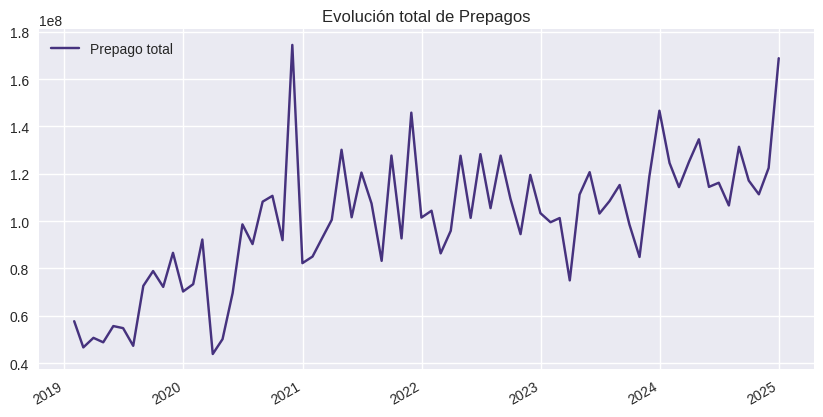

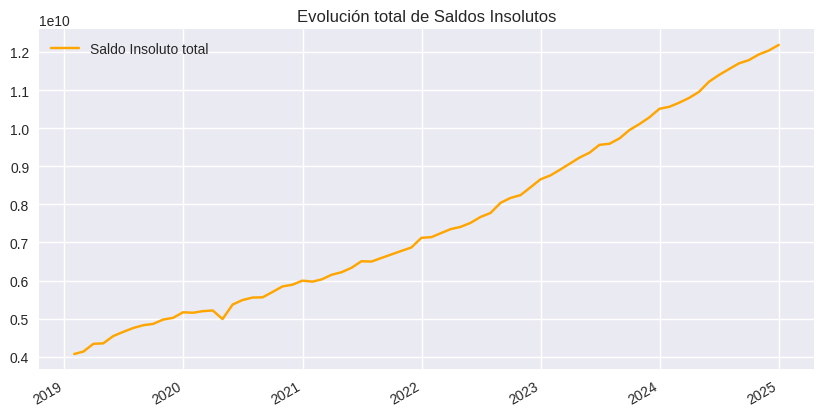

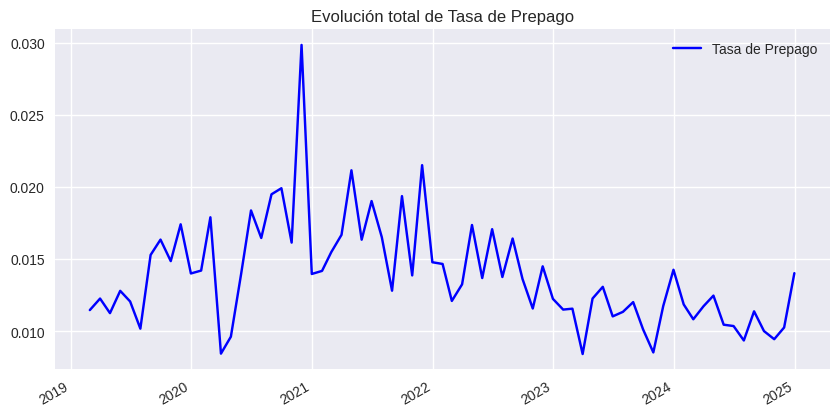

In [ ]:
cols = df_saldo.columns
fecha_cols = cols[14:]

prepago_ts = df_prepago[fecha_cols].sum()
saldo_ts = df_saldo[fecha_cols].sum()
tasa_prepago_ts = prepago_ts / saldo_ts.shift(1)

plt.figure(figsize=(10,5))
prepago_ts.plot(label="Prepago total")
plt.title("Evolución total de Prepagos")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
saldo_ts.plot(label="Saldo Insoluto total", color="orange")
plt.title("Evolución total de Saldos Insolutos")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
tasa_prepago_ts.plot(label="Tasa de Prepago", color="blue")
plt.title("Evolución total de Tasa de Prepago")
plt.legend()
plt.show()

El monto total de prepagos muestra una tendencia cíclica y ligeramente ascendente, con picos marcados hacia finales de cada año (efecto estacional típico por pagos anticipados en diciembre).

El saldo insoluto mantiene una trayectoria creciente y estable, reflejando el crecimiento orgánico del crédito y la acumulación de capital por nuevos desembolsos.

La tasa de prepago (prepagos/saldo insoluto) presenta variaciones relevantes entre 2020 y 2021, destacando un incremento en el periodo posterior a la pandemia.

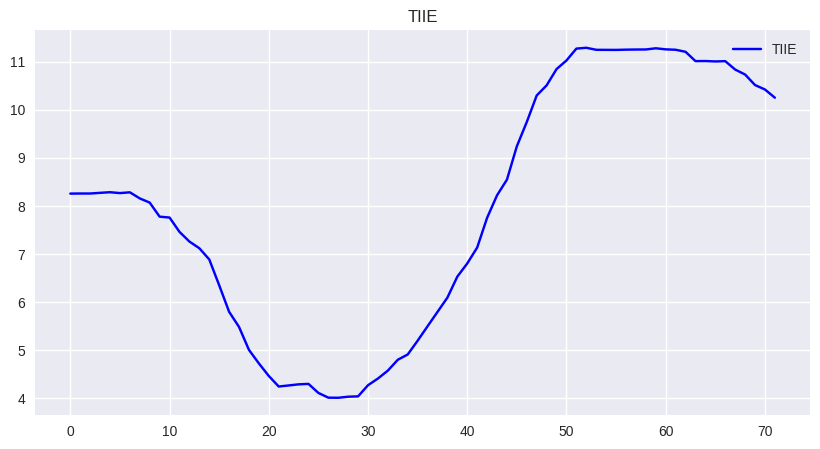

In [ ]:
plt.figure(figsize=(10,5))
df_tiie['tiie'].plot(label="TIIE", color="blue")
plt.title("TIIE")
plt.legend()
plt.show()

La TIIE (Tasa de Interés Interbancaria de Equilibrio) evidencia el ciclo de política monetaria: una caída hasta 2021 y un aumento sostenido durante 2022–2024, lo que sugiere una posible relación inversa entre TIIE y tasa de prepago (tasas altas desincentivan el prepago).

El análisis confirma la viabilidad de emplear un modelo de serie temporal multivariable para estimar la tasa de prepago.

In [ ]:
index = pd.date_range("2019-01-31", periods=72, freq="M")
serie = pd.Series(tasa_prepago_ts.values*100, index=index)
serie = serie.dropna()
serie

/tmp/ipython-input-1841893291.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index = pd.date_range("2019-01-31", periods=72, freq="M")


,0
2019-02-28,1.146488
2019-03-31,1.226422
2019-04-30,1.125386
2019-05-31,1.279943
2019-06-30,1.206334
...,...
2024-08-31,1.137825
2024-09-30,1.000886
2024-10-31,0.944625
2024-11-30,1.025859


In [ ]:
tiie = pd.Series(df_tiie['tiie'].values, index=index)
tiie = tiie.iloc[1:72]
tiie

,0
2019-02-28,8.259474
2019-03-31,8.259500
2019-04-30,8.273500
2019-05-31,8.286364
2019-06-30,8.268500
...,...
2024-08-31,10.835909
2024-09-30,10.732500
2024-10-31,10.514091
2024-11-30,10.421500


## Algoritmo

Para el modelo baseline del pronóstico de la tasa de prepagos no se considerarán variables exógenas. Se probaran modelos de suavizamiento exponencial dadas las siguientes ventajas:

- Son modelos interpretables y simples
- Permiten considerar patrones estacionales y tendencias

##1. Holt-Winters

In [ ]:
# ajuste de modelo de suavizado exponencial

serie_nov = serie.loc["2019-02-28":"2024-11-30"]
model = ExponentialSmoothing(serie_nov, trend="add", seasonal="add", seasonal_periods=12, initialization_method="estimated").fit(optimized = True)
pronostico_1_mes = model.forecast(1)

In [ ]:
print(f"Pronóstico Dic-24 en {float(pronostico_1_mes.iloc[0]):.6f}")
print(f"Dato Real  Dic-24 en {float(serie.iloc[70]):.6f}")

Pronóstico Dic-24 en 0.825232
Dato Real  Dic-24 en 1.402519


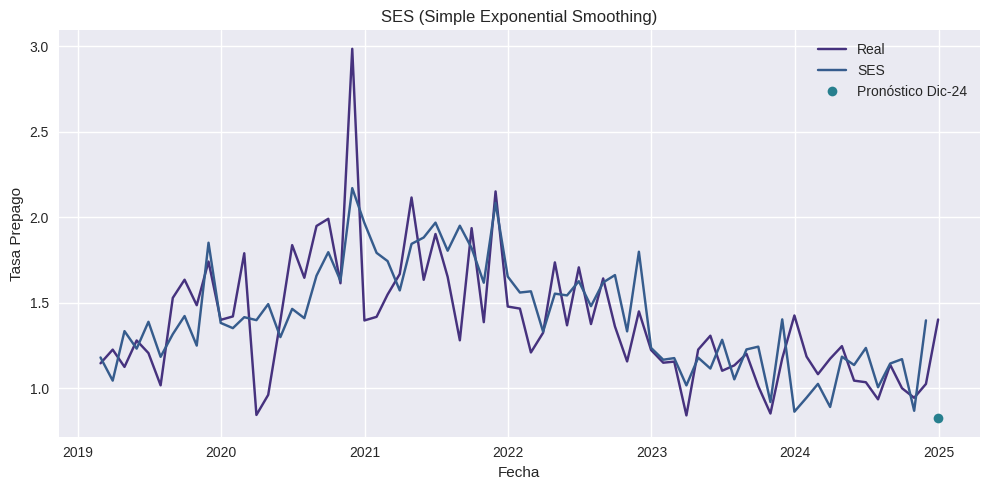

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(serie, label="Real")
plt.plot(model.fittedvalues, label="SES")

plt.plot(pronostico_1_mes.index, pronostico_1_mes.values, marker="o", linestyle="None", label="Pronóstico Dic-24")

plt.title(f"SES (Simple Exponential Smoothing)")
plt.xlabel("Fecha")
plt.ylabel("Tasa Prepago")
plt.legend()
plt.tight_layout()
plt.show()

Backtest

Se realiza un backtest de 12 meses, pronóstico un mes a cada paso, para calcular el MAE y MAPE del modelo en estos meses.

In [ ]:
backtest_months = 12
start_idx = len(serie_nov) - backtest_months

preds = []
reales = []
idx_bt = serie_nov.index[start_idx:]

for t in range(start_idx, len(serie_nov)):
    hist = serie_nov.iloc[:t]
    fit_bt = ExponentialSmoothing(hist, trend="add", seasonal="add", seasonal_periods=12, initialization_method="estimated").fit(optimized = True)
    yhat = fit_bt.forecast(1).iloc[0]
    preds.append(yhat)
    reales.append(serie_nov.iloc[t])

y_real = pd.Series(reales, index=idx_bt, name="Real")
y_pred = pd.Series(preds, index=idx_bt, name="Pronosticado")

# Métricas

MAE = float((y_real - y_pred).abs().mean())
MAPE = float(((y_real - y_pred).abs() / y_real.abs()).mean() * 100)

print("\nBacktest 1 paso (últimos", len(idx_bt), "meses) — SES con alpha optimizado en cada paso")
print(f"MAE : {MAE:.6f}")
print(f"MAPE: {MAPE:.4f}%")



Backtest 1 paso (últimos 12 meses) — SES con alpha optimizado en cada paso
MAE : 0.248158
MAPE: 21.7448%


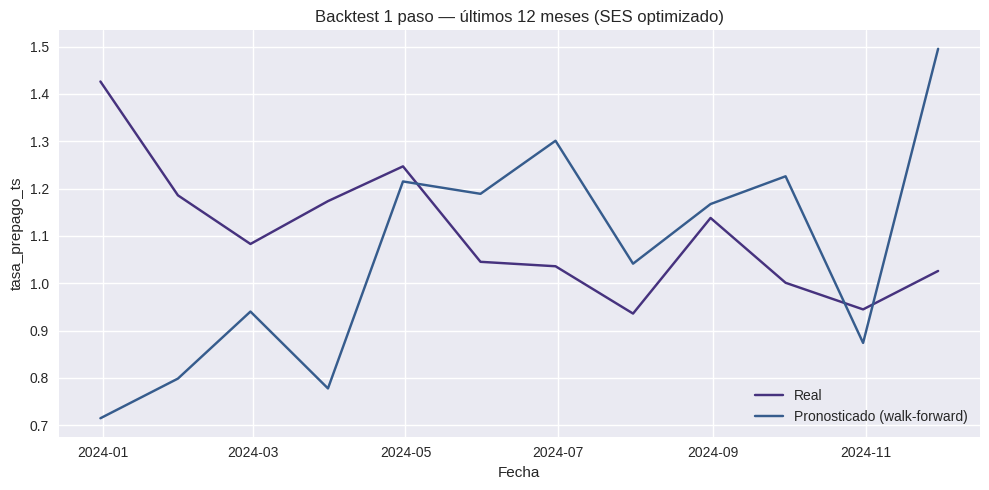

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(y_real, label="Real")
plt.plot(y_pred, label="Pronosticado (walk-forward)")
plt.title("Backtest 1 paso — últimos 12 meses (SES optimizado)")
plt.xlabel("Fecha")
plt.ylabel("tasa_prepago_ts")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

El modelo de Holt-Winters aditivo permitió capturar la tendencia y estacionalidad mensual observadas en la tasa de prepago.

A través del ajuste y el backtest realizado, se obtuvieron los siguientes resultados clave:

- El pronóstico puntual para diciembre de 2024 (0.825) subestima el valor real observado (1.40), lo que sugiere que el modelo tiende a suavizar los picos de comportamiento estacional.
- En el backtest de los últimos 12 meses, el modelo alcanzó un MAE ≈ 0.24 y un MAPE ≈ 21.7 %, valores razonables para una serie con variabilidad moderada.

##2. SES - Suavizamiento Exponencial Simple

Ahora probaremos un modelo de suavizamiento exponencial simple (SES). Este no tiene tendencia ni estacionalidad clara.

In [ ]:
# ajuste de modelo de suavizado exponencial

serie_nov = serie.loc["2019-02-28":"2024-11-30"]
model = SimpleExpSmoothing(serie_nov, initialization_method="estimated").fit(optimized = True)
pronostico_1_mes = model.forecast(1)
alpha = model.model.params.get("smoothing_level")

In [ ]:
print(f"Pronóstico Dic-24 en {float(pronostico_1_mes.iloc[0]):.6f}")
print(f"Dato Real  Dic-24 en {float(serie.iloc[70]):.6f}")

Pronóstico Dic-24 en 1.038161
Dato Real  Dic-24 en 1.402519


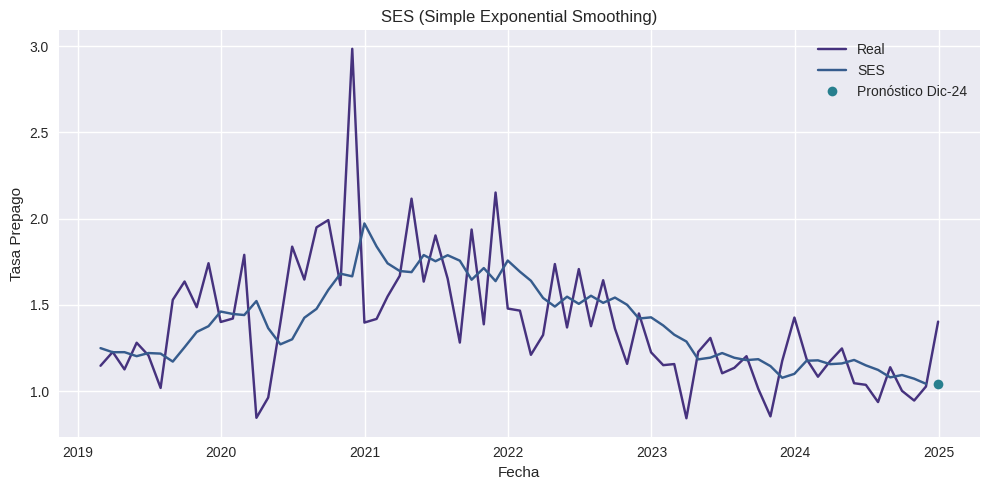

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(serie, label="Real")
plt.plot(model.fittedvalues, label="SES")

plt.plot(pronostico_1_mes.index, pronostico_1_mes.values, marker="o", linestyle="None", label="Pronóstico Dic-24")

plt.title(f"SES (Simple Exponential Smoothing)")
plt.xlabel("Fecha")
plt.ylabel("Tasa Prepago")
plt.legend()
plt.tight_layout()
plt.show()

Backtest

Se realiza un backtest de 12 meses, pronóstico un mes a cada paso, para calcular el MAE y MAPE del modelo en estos meses.

In [ ]:
backtest_months = 12
start_idx = len(serie_nov) - backtest_months

preds = []
reales = []
idx_bt = serie_nov.index[start_idx:]

for t in range(start_idx, len(serie_nov)):
    hist = serie_nov.iloc[:t]
    fit_bt = SimpleExpSmoothing(hist, initialization_method="estimated").fit(optimized=True)
    yhat = fit_bt.forecast(1).iloc[0]
    preds.append(yhat)
    reales.append(serie_nov.iloc[t])

y_real = pd.Series(reales, index=idx_bt, name="Real")
y_pred = pd.Series(preds, index=idx_bt, name="Pronosticado")

# Métricas

MAE = float((y_real - y_pred).abs().mean())
MAPE = float(((y_real - y_pred).abs() / y_real.abs()).mean() * 100)

print("\nBacktest 1 paso (últimos", len(idx_bt), "meses)")
print(f"MAE : {MAE:.6f}")
print(f"MAPE: {MAPE:.4f}%")



Backtest 1 paso (últimos 12 meses)
MAE : 0.105528
MAPE: 9.5232%


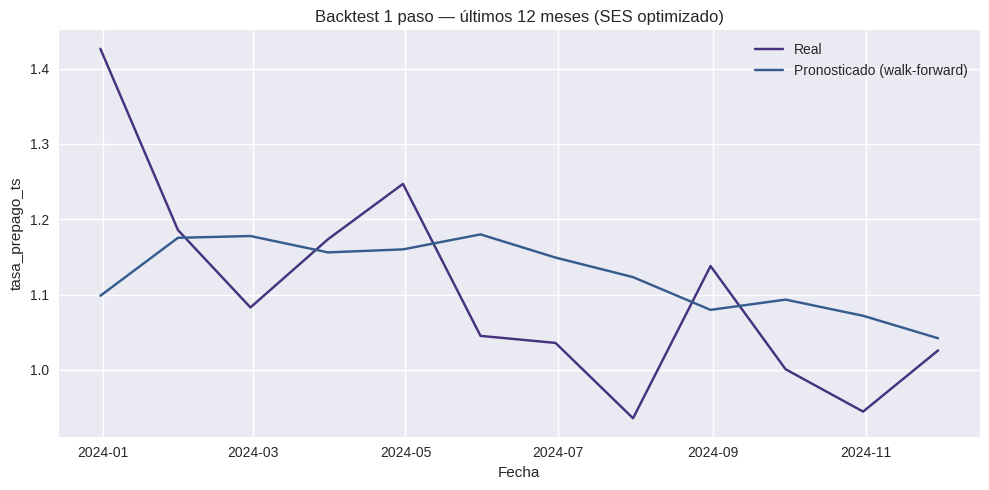

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(y_real, label="Real")
plt.plot(y_pred, label="Pronosticado (walk-forward)")
plt.title("Backtest 1 paso — últimos 12 meses (SES optimizado)")
plt.xlabel("Fecha")
plt.ylabel("tasa_prepago_ts")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

El modelo de suavizamiento exponencial simple (SES) se aplicó como un enfoque base para estimar la tasa de prepago, bajo el supuesto de ausencia de tendencia y estacionalidad.

Los resultados del pronóstico y la validación muestran que:

- El pronóstico para diciembre de 2024 se aproxima de forma razonable al valor real observado, mostrando una subestimación leve atribuible a la naturaleza suavizada del modelo.
- Visualmente, el modelo sigue adecuadamente la tendencia general de la serie, aunque tiende a amortiguar los picos de prepago.

##3. VAR

Modelo multivariante.

In [ ]:
# ajuste


df = pd.concat([serie, tiie], axis=1)
df.columns = ['serie', 'tiie']

h = 1
train, test = df.iloc[:-h], df.iloc[-h:]

model = VAR(train)
res = model.fit(maxlags=12, ic='aic')

lags = res.k_ar
pronostico_1_mes = res.forecast(y=train.values[-lags:], steps=h)

fc_df = pd.DataFrame(pronostico_1_mes, index=test.index, columns=train.columns)

y_hat = fc_df['serie']

In [ ]:
print(f"Pronóstico Dic-24 en {float(y_hat.iloc[0]):.6f}")
print(f"Dato Real  Dic-24 en {float(serie.iloc[70]):.6f}")

Pronóstico Dic-24 en 1.207384
Dato Real  Dic-24 en 1.402519


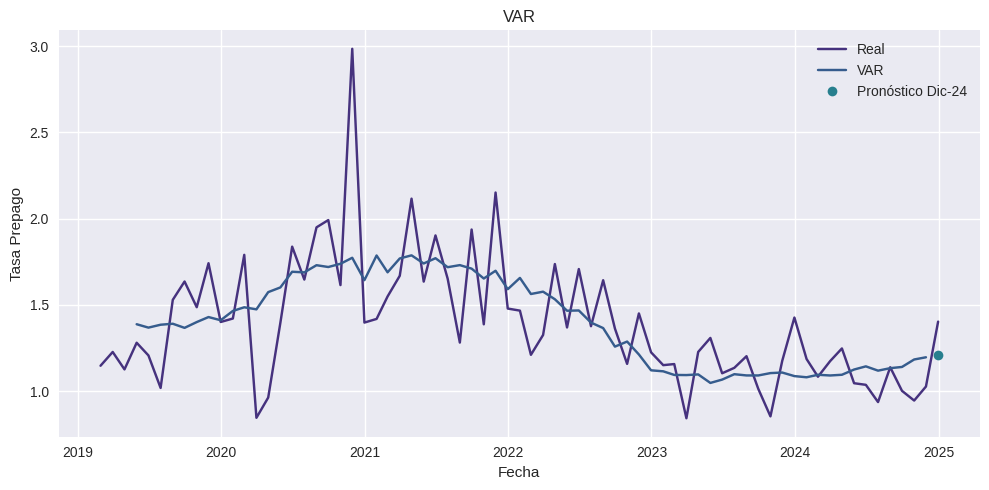

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(serie, label="Real")
plt.plot(res.fittedvalues['serie'], label="VAR")

plt.plot(serie.index[70], y_hat, marker="o", linestyle="None", label="Pronóstico Dic-24")

plt.title(f"VAR")
plt.xlabel("Fecha")
plt.ylabel("Tasa Prepago")
plt.legend()
plt.tight_layout()
plt.show()

Backtest

Se realiza un backtest de 12 meses, pronóstico un mes a cada paso, para calcular el MAE y MAPE del modelo en estos meses.

In [ ]:
backtest_months = 12
start_idx = len(serie_nov) - backtest_months

preds = []
reales = []
idx_bt = serie_nov.index[start_idx:]

for t in range(start_idx, len(serie_nov)):
    hist = serie_nov.iloc[:t]
    hist2 = tiie.iloc[:t]
    df = pd.concat([hist, hist2], axis=1)
    df.columns = ['serie', 'tiie']


    train, test = df.iloc[:-1], df.iloc[-1:]

    model = VAR(train)
    res = model.fit(maxlags=12, ic='aic')

    lags = res.k_ar
    pronostico_1_mes = res.forecast(y=train.values[-lags:], steps=1)

    fc_df = pd.DataFrame(pronostico_1_mes, index=test.index, columns=train.columns)

    y_hat = fc_df['serie']

    preds.append(y_hat.iloc[0])
    reales.append(serie_nov.iloc[t])

y_real = pd.Series(reales, index=idx_bt, name="Real")
y_pred = pd.Series(preds, index=idx_bt, name="Pronosticado")

# Métricas

MAE = float((y_real - y_pred).abs().mean())
MAPE = float(((y_real - y_pred).abs() / y_real.abs()).mean() * 100)

print("\nBacktest 1 paso (últimos", len(idx_bt), "meses)")
print(f"MAE : {MAE:.6f}")
print(f"MAPE: {MAPE:.4f}%")



Backtest 1 paso (últimos 12 meses)
MAE : 0.142003
MAPE: 12.9967%


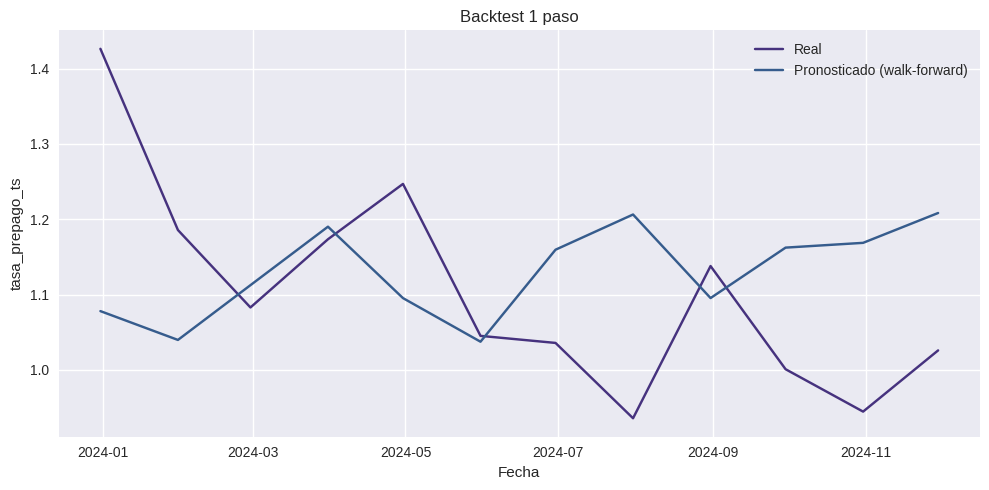

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(y_real, label="Real")
plt.plot(y_pred, label="Pronosticado (walk-forward)")
plt.title("Backtest 1 paso")
plt.xlabel("Fecha")
plt.ylabel("tasa_prepago_ts")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Los resultados muestran que el modelo logra capturar adecuadamente la tendencia general de la serie, aunque presenta una ligera sobreestimación en el pronóstico:

- El pronóstico para diciembre de 2024 se ubicó por encima del valor real observado, lo que indica que el modelo sobrerreacciona levemente ante incrementos de la TIIE o periodos de alza en la serie.
- En el backtest de los últimos 12 meses, se obtuvo un MAE = 0.14 y un MAPE = 13 %, métricas que evidencian buen ajuste y menor error promedio frente a los modelos univariantes (SES y Holt-Winters).

##4. Prophet



In [ ]:
# ajuste

df = pd.DataFrame({'ds': serie.index, 'y': serie.values,
                   'TIIE': tiie.values})

cut = df['ds'] < pd.to_datetime('2024-12-31')
df_tr, df_te = df[cut], df[~cut]

m = Prophet()
m.add_regressor('TIIE')
m.fit(df_tr)

forecast = m.predict(df_te[['ds','TIIE']])
y_hat = forecast['yhat'].set_axis(df_te['ds'])

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvrq3h9ol/qbpp3cj3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvrq3h9ol/qak3jcm6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48251', 'data', 'file=/tmp/tmpvrq3h9ol/qbpp3cj3.json', 'init=/tmp/tmpvrq3h9ol/qak3jcm6.json', 'output', 'file=/tmp/tmpvrq3h9ol/prophet_model2_5n8m5y/prophet_model-20251019084643.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
08:46:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:46:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
pronostico_1_mes = y_hat

In [ ]:
print(f"Pronóstico Dic-24 en {float(pronostico_1_mes.iloc[0]):.6f}")
print(f"Dato Real  Dic-24 en {float(serie.iloc[70]):.6f}")

Pronóstico Dic-24 en 0.901639
Dato Real  Dic-24 en 1.402519


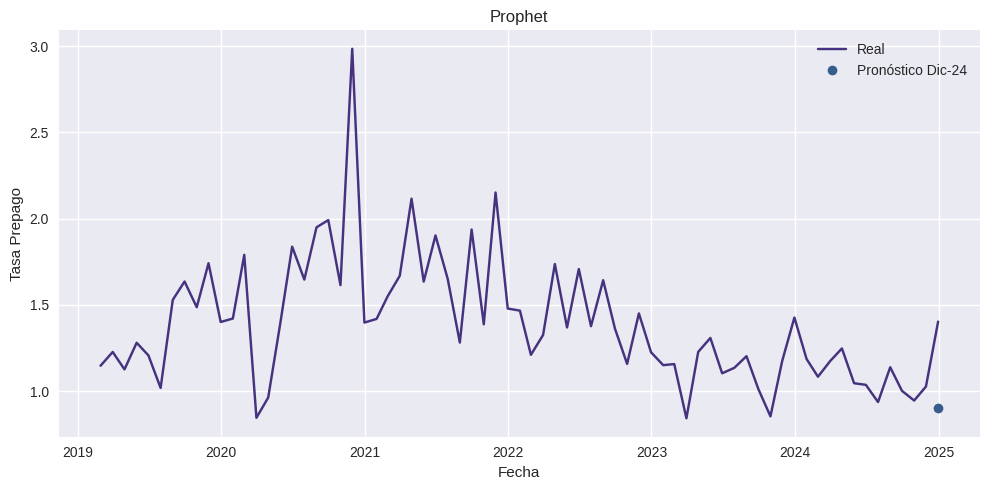

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(serie, label="Real")

plt.plot(pronostico_1_mes.index, pronostico_1_mes.values, marker="o", linestyle="None", label="Pronóstico Dic-24")

plt.title(f"Prophet")
plt.xlabel("Fecha")
plt.ylabel("Tasa Prepago")
plt.legend()
plt.tight_layout()
plt.show()

Backtest

Se realiza un backtest de 12 meses, pronóstico un mes a cada paso, para calcular el MAE y MAPE del modelo en estos meses.

In [ ]:
backtest_months = 12
start_idx = len(serie_nov) - backtest_months

preds = []
reales = []
idx_bt = serie_nov.index[start_idx:]

for t in range(start_idx, len(serie_nov)):
    hist = serie_nov.iloc[:t]
    hist2 = tiie.iloc[:t]

    df = pd.DataFrame({'ds': hist.index, 'y': hist.values,
                   'TIIE': hist2.values})

    cut = df['ds'] < pd.to_datetime(serie_nov.index[len(hist)-1])
    df_tr, df_te = df[cut], df[~cut]

    m = Prophet()
    m.add_regressor('TIIE')
    m.fit(df_tr)

    forecast = m.predict(df_te[['ds','TIIE']])
    y_hat = forecast['yhat'].set_axis(df_te['ds'])

    preds.append(y_hat.iloc[0])
    reales.append(serie_nov.iloc[t])

y_real = pd.Series(reales, index=idx_bt, name="Real")
y_pred = pd.Series(preds, index=idx_bt, name="Pronosticado")


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvrq3h9ol/zr85thnh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvrq3h9ol/a567yvmg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30736', 'data', 'file=/tmp/tmpvrq3h9ol/zr85thnh.json', 'init=/tmp/tmpvrq3h9ol/a567yvmg.json', 'output', 'file=/tmp/tmpvrq3h9ol/prophet_model4e_zcd8s/prophet_model-20251019084643.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
08:46:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:46:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonali

In [ ]:

# Métricas

MAE = float((y_real - y_pred).abs().mean())
MAPE = float(((y_real - y_pred).abs() / y_real.abs()).mean() * 100)

print("\nBacktest 1 paso (últimos", len(idx_bt), "meses)")
print(f"MAE : {MAE:.6f}")
print(f"MAPE: {MAPE:.4f}%")



Backtest 1 paso (últimos 12 meses)
MAE : 0.161359
MAPE: 15.3478%


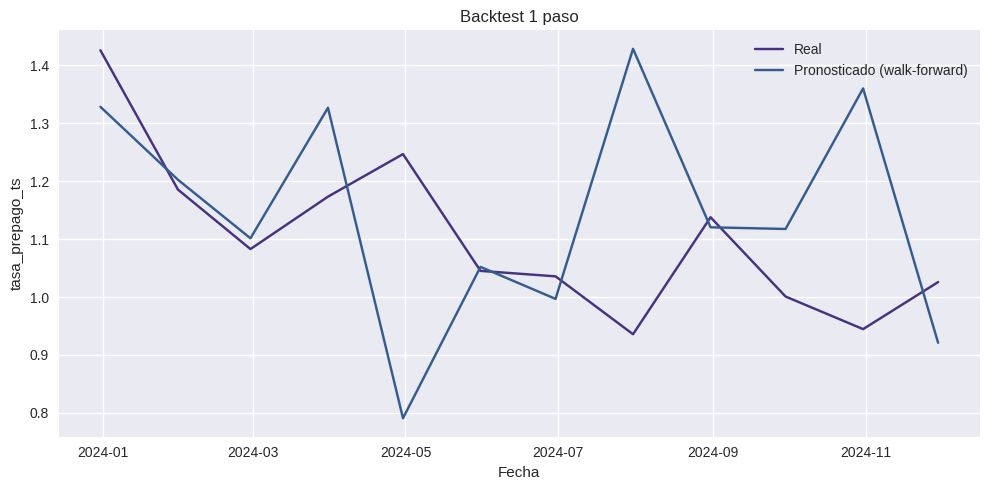

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(y_real, label="Real")
plt.plot(y_pred, label="Pronosticado (walk-forward)")
plt.title("Backtest 1 paso")
plt.xlabel("Fecha")
plt.ylabel("tasa_prepago_ts")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Los resultados muestran que Prophet mantiene la tendencia general de la serie, pero presenta desajustes significativos tanto al alza como a la baja respecto a los valores reales:

- El pronóstico para diciembre de 2024 quedó considerablemente por debajo del valor real, y en el backtest se observan periodos donde el modelo también sobreestima los valores intermedios.
- Las variaciones indican que el modelo no logra seguir con precisión la volatilidad mensual, reflejando un exceso de suavizamiento en escenarios de alta variabilidad.
- El desempeño cuantitativo arroja un MAE = 0.16 y un MAPE = 15.3 %, lo que confirma una menor precisión relativa frente a los modelos VAR y Holt-Winters.

##5. XGBoost



In [ ]:
# ajuste

X = tiie_nov.to_frame(name='TIIE')
y = serie_nov

model = XGBRegressor(
    n_estimators=600, learning_rate=0.05, max_depth=4,
    subsample=0.8, colsample_bytree=0.8, random_state=0
)
model.fit(X, y)

x_new = pd.DataFrame({'TIIE': [tiie.iloc[70]]}, index=[tiie.index[70]])
y_hat = pd.Series(model.predict(x_new), index=x_new.index)

In [ ]:
print(f"Pronóstico Dic-24 en {float(y_hat.iloc[0]):.6f}")
print(f"Dato Real  Dic-24 en {float(serie.iloc[70]):.6f}")

Pronóstico Dic-24 en 1.437522
Dato Real  Dic-24 en 1.402519


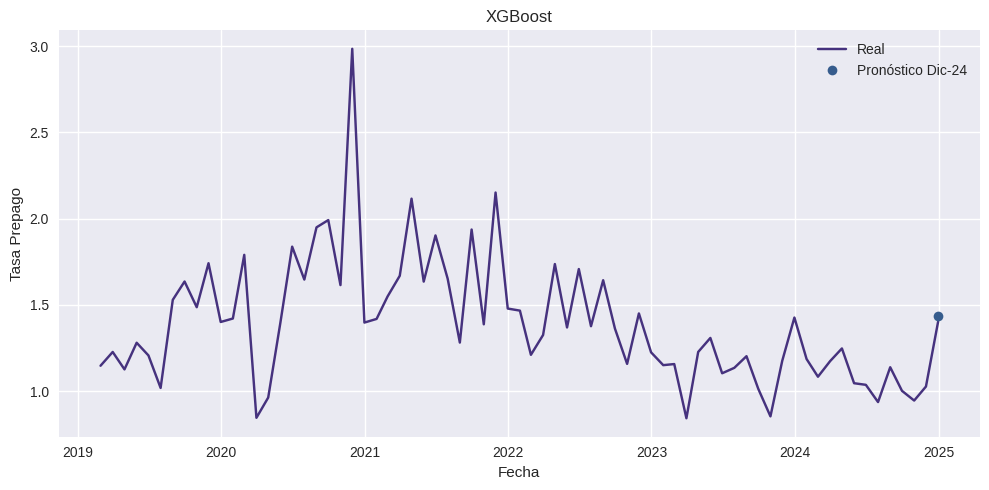

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(serie, label="Real")

plt.plot(y_hat.index, y_hat.values, marker="o", linestyle="None", label="Pronóstico Dic-24")

plt.title(f"XGBoost")
plt.xlabel("Fecha")
plt.ylabel("Tasa Prepago")
plt.legend()
plt.tight_layout()
plt.show()

Backtest

Se realiza un backtest de 12 meses, pronóstico un mes a cada paso, para calcular el MAE y MAPE del modelo en estos meses.

In [ ]:
backtest_months = 12
start_idx = len(serie_nov) - backtest_months

preds = []
reales = []
idx_bt = serie_nov.index[start_idx:]

for t in range(start_idx, len(serie_nov)):
    hist = serie_nov.iloc[:t]
    hist2 = tiie_nov.iloc[:t]

    X = hist2.to_frame(name='TIIE')
    y = hist

    model = XGBRegressor(
        n_estimators=600, learning_rate=0.05, max_depth=4,
        subsample=0.8, colsample_bytree=0.8, random_state=0
    )
    model.fit(X, y)

    x_new = pd.DataFrame({'TIIE': [tiie_nov.iloc[t]]}, index=[tiie_nov.index[t]])
    y_hat = pd.Series(model.predict(x_new), index=x_new.index)

    preds.append(y_hat.iloc[0])
    reales.append(serie_nov.iloc[t])

y_real = pd.Series(reales, index=idx_bt, name="Real")
y_pred = pd.Series(preds, index=idx_bt, name="Pronosticado")

# Métricas

MAE = float((y_real - y_pred).abs().mean())
MAPE = float(((y_real - y_pred).abs() / y_real.abs()).mean() * 100)

print("\nBacktest 1 paso (últimos", len(idx_bt), "meses)")
print(f"MAE : {MAE:.6f}")
print(f"MAPE: {MAPE:.4f}%")



Backtest 1 paso (últimos 12 meses)
MAE : 0.137975
MAPE: 12.7057%


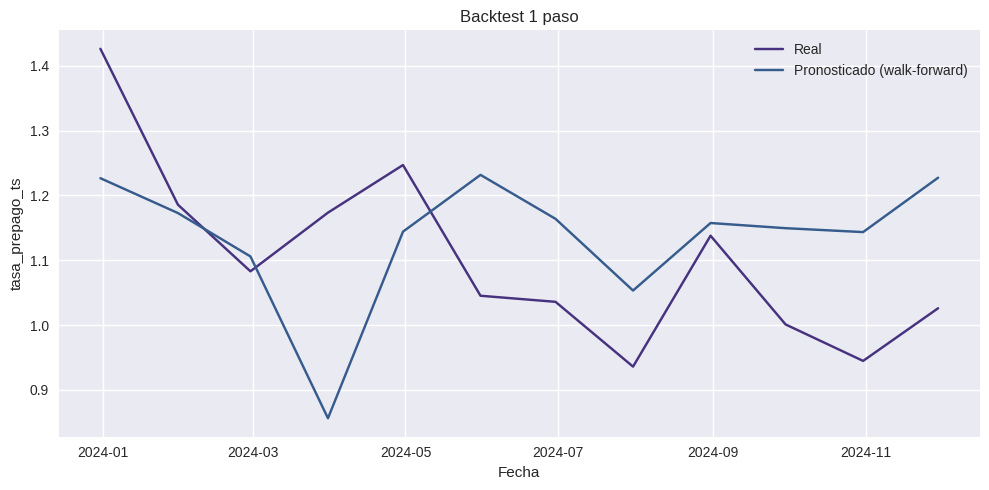

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(y_real, label="Real")
plt.plot(y_pred, label="Pronosticado (walk-forward)")
plt.title("Backtest 1 paso")
plt.xlabel("Fecha")
plt.ylabel("tasa_prepago_ts")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Los resultados muestran un pronóstico cercano al valor real, aunque con una ligera tendencia al alza, es decir, a sobreestimar la tasa de prepago en algunos periodos:

- El pronóstico para diciembre de 2024 se ubicó ligeramente por encima del valor real, lo que refleja un sesgo positivo leve.
- En el backtest de los últimos 12 meses, el modelo alcanzó un MAE = 0.1379 y un MAPE = 12.8 %, posicionándose entre los de mejor precisión global, aunque con variaciones direccionales en meses puntuales.
- Se observan episodios de sobreestimación local, donde el modelo responde con mayor intensidad ante cambios en la tendencia reciente.

##6. Random Forest Regressor



In [ ]:
# ajuste

X = tiie_nov.to_frame(name='TIIE')
y = serie_nov

rf = RandomForestRegressor(
    n_estimators=400, max_depth=12, min_samples_leaf=5,
    max_features='sqrt', random_state=42, n_jobs=-1
)
rf.fit(X, y)

x_new = pd.DataFrame({'TIIE': [tiie.iloc[70]]}, index=[tiie.index[70]])
y_hat = pd.Series(rf.predict(x_new), index=x_new.index)

In [ ]:
print(f"Pronóstico Dic-24 en {float(y_hat.iloc[0]):.6f}")
print(f"Dato Real  Dic-24 en {float(serie.iloc[70]):.6f}")

Pronóstico Dic-24 en 1.162850
Dato Real  Dic-24 en 1.402519


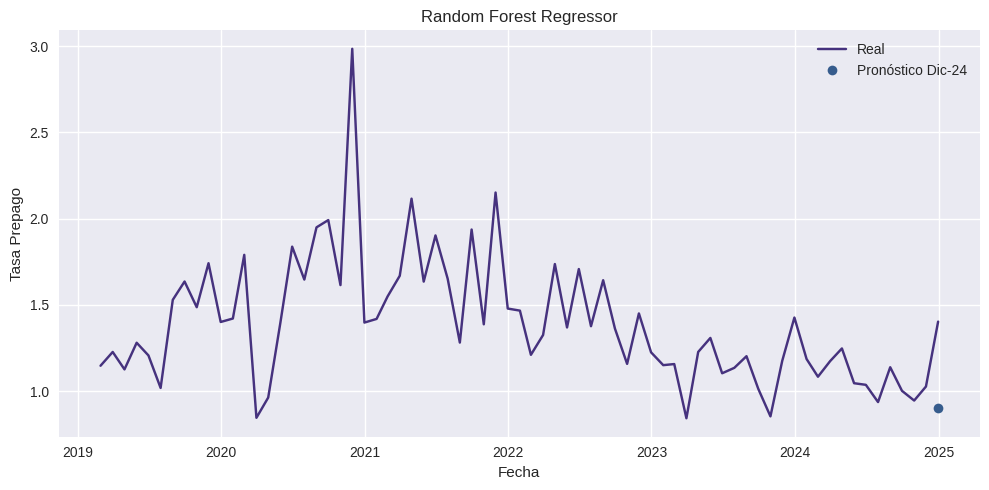

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(serie, label="Real")

plt.plot(pronostico_1_mes.index, pronostico_1_mes.values, marker="o", linestyle="None", label="Pronóstico Dic-24")

plt.title(f"Random Forest Regressor")
plt.xlabel("Fecha")
plt.ylabel("Tasa Prepago")
plt.legend()
plt.tight_layout()
plt.show()

Backtest

Se realiza un backtest de 12 meses, pronóstico un mes a cada paso, para calcular el MAE y MAPE del modelo en estos meses.

In [ ]:
backtest_months = 12
start_idx = len(serie_nov) - backtest_months

preds = []
reales = []
idx_bt = serie_nov.index[start_idx:]

for t in range(start_idx, len(serie_nov)):
    hist = serie_nov.iloc[:t]
    hist2 = tiie_nov.iloc[:t]

    X = hist2.to_frame(name='TIIE')
    y = hist

    rf = RandomForestRegressor(
        n_estimators=400, max_depth=12, min_samples_leaf=5,
        max_features='sqrt', random_state=42, n_jobs=-1
    )
    rf.fit(X, y)

    x_new = pd.DataFrame({'TIIE': [tiie_nov.iloc[t]]}, index=[tiie_nov.index[t]])
    y_hat = pd.Series(rf.predict(x_new), index=x_new.index)

    preds.append(y_hat.iloc[0])
    reales.append(serie_nov.iloc[t])

y_real = pd.Series(reales, index=idx_bt, name="Real")
y_pred = pd.Series(preds, index=idx_bt, name="Pronosticado")

# Métricas

MAE = float((y_real - y_pred).abs().mean())
MAPE = float(((y_real - y_pred).abs() / y_real.abs()).mean() * 100)

print("\nBacktest 1 paso (últimos", len(idx_bt), "meses)")
print(f"MAE : {MAE:.6f}")
print(f"MAPE: {MAPE:.4f}%")



Backtest 1 paso (últimos 12 meses)
MAE : 0.121469
MAPE: 11.0605%


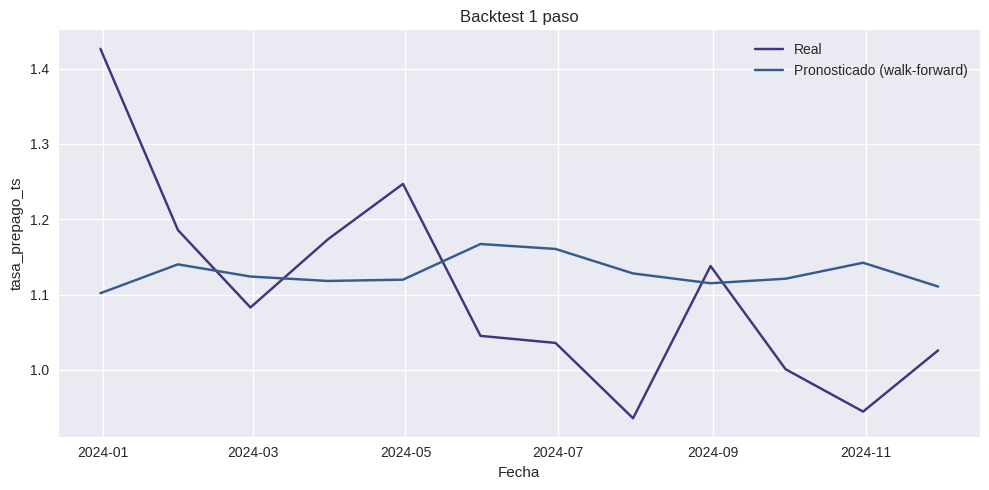

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(y_real, label="Real")
plt.plot(y_pred, label="Pronosticado (walk-forward)")
plt.title("Backtest 1 paso")
plt.xlabel("Fecha")
plt.ylabel("tasa_prepago_ts")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

El Random Forest Regressor muestra un sesgo inconsistente: en algunos meses subestima y en otros sobreestima la tasa de prepago.

El pronóstico puntual de dic-24 refleja sesgo a la baja en ese corte, pero el backtest evidencia episodios de sobreestimación y suavización excesiva (no sigue bien picos/caídas).

Es un modelo estable pero poco reactivo; útil como base conservadora.


Dados los resultados, elegimos XGBoost y Random Forest Regressor para calibrar, ajustando los hiperparámetros.

##Calibración XGBoost

In [ ]:
backtest_months = 12
start_idx = len(serie_nov) - backtest_months

preds = []
reales = []
idx_bt = serie_nov.index[start_idx:]

for t in range(start_idx, len(serie_nov)):
    hist = serie_nov.iloc[:t]
    hist2 = tiie_nov.iloc[:t]

    X = hist2.to_frame(name='TIIE')
    y = hist

    model = XGBRegressor(
        n_estimators=500, learning_rate=0.5, max_depth=5, colsample_bytree=0.5, random_state=0
    )
    model.fit(X, y)

    x_new = pd.DataFrame({'TIIE': [tiie_nov.iloc[t]]}, index=[tiie_nov.index[t]])
    y_hat = pd.Series(model.predict(x_new), index=x_new.index)

    preds.append(y_hat.iloc[0])
    reales.append(serie_nov.iloc[t])

y_real = pd.Series(reales, index=idx_bt, name="Real")
y_pred = pd.Series(preds, index=idx_bt, name="Pronosticado")

# Métricas

MAE = float((y_real - y_pred).abs().mean())
MAPE = float(((y_real - y_pred).abs() / y_real.abs()).mean() * 100)

print("\nBacktest 1 paso (últimos", len(idx_bt), "meses)")
print(f"MAE : {MAE:.6f}")
print(f"MAPE: {MAPE:.4f}%")


Backtest 1 paso (últimos 12 meses)
MAE : 0.136489
MAPE: 12.5595%


##Calibración Random Forest Regressor

In [ ]:
backtest_months = 12
start_idx = len(serie_nov) - backtest_months

preds = []
reales = []
idx_bt = serie_nov.index[start_idx:]

for t in range(start_idx, len(serie_nov)):
    hist = serie_nov.iloc[:t]
    hist2 = tiie_nov.iloc[:t]

    X = hist2.to_frame(name='TIIE')
    y = hist

    rf = RandomForestRegressor(
        n_estimators=400, max_depth=10, min_samples_leaf=5,
        max_features='sqrt', random_state=0
    )
    rf.fit(X, y)

    x_new = pd.DataFrame({'TIIE': [tiie_nov.iloc[t]]}, index=[tiie_nov.index[t]])
    y_hat = pd.Series(rf.predict(x_new), index=x_new.index)

    preds.append(y_hat.iloc[0])
    reales.append(serie_nov.iloc[t])

y_real = pd.Series(reales, index=idx_bt, name="Real")
y_pred = pd.Series(preds, index=idx_bt, name="Pronosticado")

# Métricas

MAE = float((y_real - y_pred).abs().mean())
MAPE = float(((y_real - y_pred).abs() / y_real.abs()).mean() * 100)

print("\nBacktest 1 paso (últimos", len(idx_bt), "meses)")
print(f"MAE : {MAE:.6f}")
print(f"MAPE: {MAPE:.4f}%")


Backtest 1 paso (últimos 12 meses)
MAE : 0.120422
MAPE: 10.9865%


##Modelo Individual

Tras la calibración y evaluación de desempeño de los distintos modelos de regresión aplicados a la tasa de prepago, se compararon las métricas de precisión (MAE y MAPE), la estabilidad del error, y el sesgo direccional de las predicciones.


El modelo XGBoost presenta una mayor capacidad de respuesta ante variaciones abruptas, pero tiende a sobreestimar la tasa de prepago, mostrando un sesgo positivo recurrente.

El Random Forest Regressor, en cambio, ofrece un desempeño más equilibrado, con errores más uniformes y una mejor capacidad de generalización. Su naturaleza de ensamble lo hace menos propenso al sobreajuste y más consistente en horizontes de tiempo prolongados.

Por lo anterior, se selecciona el Random Forest Regressor como el modelo principal de calibración para el pronóstico de la tasa de prepago, dado que este modelo logra menor error absoluto y porcentual, presenta mayor robustez frente a variaciones exógenas moderadas y mantiene un equilibrio adecuado entre precisión y estabilidad.